#[1] Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#[2] Setting up Environment and Install Requirements

In [30]:
import os
import sys
# Set Path
path_wd = '/content/drive/MyDrive/Github/Content'
os.chdir(path_wd)

!pip install transformers
!pip install -r sources/ChinaFilm/requirements.txt
!apt-get update # to update ubuntu to correctly run apt install
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
!pip install selenium
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')

import pandas as pd
import numpy as np
import datetime as dt
import re
import random
import jieba.analyse
tfidf = jieba.analyse.extract_tags
textrank = jieba.analyse.textrank

     |████████████████████████████████| 2.5MB 5.0MB/s 
     |████████████████████████████████| 901kB 32.2MB/s 
     |████████████████████████████████| 3.3MB 36.0MB/s 
Hit:1 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://archive.ubuntu.com/ubunt

# [3] Load Release and Registration Records

In [3]:
# ImportImport Releases
path_releases = '/content/drive/MyDrive/Github/Content/sources/ChinaFilm/records/contents_of_releases.csv'
df_releases = pd.read_csv(path_releases, index_col=0, encoding='utf-8')

# Import Reg
path_regs = '/content/drive/MyDrive/Github/Content/sources/ChinaFilm/records/contents_of_registrations.csv'
df_reg = pd.read_csv(path_regs, index_col=0, encoding='utf-8')
df_reg['匹配片名'] = df_reg['片名']


# Get Latest Issue
str_date_curr_release = df_releases.sort_values(by='公示日期', ascending=False).iloc[0]['公示日期']
dt_curr_release = dt.datetime.strptime(str_date_curr_release, '%Y-%m-%d')
df_curr_releases = df_releases[df_releases['公示日期']==str_date_curr_release]
df_curr_releases = df_curr_releases[['电影类别', '编码', '公映证号', '片名', '第一出品单位']].copy()

In [4]:
df_curr_releases.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55 entries, 1 to 55
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   电影类别    55 non-null     object
 1   编码      55 non-null     object
 2   公映证号    55 non-null     object
 3   片名      55 non-null     object
 4   第一出品单位  55 non-null     object
dtypes: object(5)
memory usage: 2.6+ KB


In [ ]:
# Check for unmatched records and perform mannual matches
df_matched = df_reg[df_reg['匹配片名'].isin(df_curr_releases['片名'].to_numpy())]
df_curr_releases.loc[~df_curr_releases['片名'].isin(df_matched['片名'].to_numpy())]

,电影类别,编码,公映证号,片名,第一出品单位
序号,,,,,
1,国产故事片,1100032021,3,只是一次偶然的旅行,上海腾讯企鹅影视文化传播有限公司
2,国产故事片,1100722021,9,宋庆龄和福利院的孩子们,八一电影制片厂
7,国产故事片,1101622021,81,永远的记忆之血战黎明前,西安沣镐嘉艺影视文化传播有限公司
8,国产故事片,1100942021,90,天下第一镖2长风厉,北京盛世华映影视文化传播有限公司
11,国产故事片,1101122021,108,兴凯湖畔,鸡西东方紫光传媒有限公司
13,国产故事片,1101272021,117,非常·主播,深圳市子砚影视文化传媒有限公司
15,国产故事片,1101372021,128,乡医老牛（吕剧）,山东新农村数字电影院线有限公司
17,国产故事片,1101442021,135,站着等你三千年,连江达康影视投资有限公司
18,国产故事片,1101482021,138,抗倭传奇,北京信义时代电影股份有限公司


In [5]:
df_reg.loc[df_reg['备案单位'].fillna('').str.contains('驻马店市影视文'), ['片名', '备案单位', '编剧', '梗概']]


,片名,备案单位,编剧,梗概
电影类别,,,,
故事影片,老师妈妈,驻马店市影视文化有限公司,周明理,人民教师刘月娟，象妈妈一样不仅关心留守儿童的学习，更关心孩子们的成长，关心留守儿童的生活，用...
故事影片,打铁花,驻马店市影视文化有限公司、驻马店市上善文化传播有限公司,刘康健,共产党人彭皓天认识唱戏的艺麻五，二人结为好友。后来彭雪松被国民党追杀，临死前对唱麻五说明了真...
故事影片,家有贤妻（戏曲片 ）,驻马店市影视文化有限公司,周明理,电影《家有贤妻》以“亲情、真情、感情”为主题，以乔石林当选村长为切入点，讲述了妻子红梅在乔石...


In [6]:
df_reg.columns

Index(['备案立项号', '片名', '备案单位', '编剧', '备案结果', '备案地', '梗概', '公示日期', '公示批次名称',
       '备案详细页链接', '公示批次链接', '匹配片名'],
      dtype='object')

In [7]:
mmatch = {
          '只是一次偶然的旅行':'昆的故事',
          '宋庆龄和福利院的孩子们':'怒放',
          '永远的记忆之血战黎明前':'永远的记忆',
          '天下第一镖2长风厉':'天下第一镖局2',
          '兴凯湖畔':'兴凯湖畔的女人',
          '非常·主播':'我不是网红',
          '乡医老牛（吕剧）':'乡医老牛',
          '站着等你三千年':'星际之恋',
          '抗倭传奇':'抗倭',
          '黄庙村·地宫美人':'美人怨',
          '别让我走':'敞开的门',
          '火光·绽放':'火光（上）',
          '火光·重生':'火光（下）',
          '二哥来了怎么办':'快把我2哥带走',
          '狗果定理':'幸福像果汁儿一样',
          '狗果定理':'幸福像果汁一样',
          '1921':'星辰大海',
          '杜鹃改嫁（下）吕剧':'杜鹃改嫁',
          '你们不在的时光':'老师妈妈',
          '幸福的她们':'北方爱情故事',
          '顺子加油':'最好的青春',
          '盗狗':'落难忠犬',
          '我是监护人':'落地生'
          }

In [ ]:
df_reg.loc[df_reg['梗概'].str.contains('谜棺')]
# 射雕英雄传之九阴白骨瓜 from release
# 射雕英雄传之九阴白骨爪 in reg

In [9]:
df_curr_releases['匹配片名'] = df_curr_releases['片名'].apply(lambda x: mmatch[x] if x in mmatch else x)
df_matched = df_reg[df_reg['匹配片名'].isin(df_curr_releases['匹配片名'].to_numpy())]
df_matched = df_matched[['备案立项号', '匹配片名', '备案单位', '编剧', '备案结果', '备案地', '梗概', '公示日期']].copy()
df_matched.rename(columns={'公示日期':'备案公示日期'}, inplace=True)
df_c = df_curr_releases.merge(df_matched, on='匹配片名', how='left')
df_c['备案公示日期'] = df_c['备案公示日期'].apply(lambda x: pd.to_datetime(x, infer_datetime_format=True))
df_c['备案至今'] = dt_curr_release - df_c['备案公示日期']

In [ ]:
df_matched

In [ ]:
# Manually Fix unmerged matches


In [ ]:
df_c

In [12]:
# drop incomplete record and manually drop records with same name but not of same project
df = df_c.dropna().copy()
idx_to_drop = [2]
df.drop(idx_to_drop, inplace=True)

# [4.2] Assign Time Period and Genre Label

In [32]:
len(id2label_time)

4

In [33]:
id2label_time = {0: '古代', 1: '当代', 2: '现代', 3: '近代'}
label2id_time = {'古代': 0, '当代': 1, '现代': 2, '近代': 3}
Nlabels_time = len(id2label_time)

id2label_genre = {0: '传奇',
                  1: '传记',
                  2: '其它',
                  3: '军旅',
                  4: '农村',
                  5: '宫廷',
                  6: '武打',
                  7: '涉案',
                  8: '神话',
                  9: '科幻',
                  10: '都市',
                  11: '青少',
                  12: '革命'}

label2id_genre = {'传奇': 0,
                  '传记': 1,
                  '其它': 2,
                  '军旅': 3,
                  '农村': 4,
                  '宫廷': 5,
                  '武打': 6,
                  '涉案': 7,
                  '神话': 8,
                  '科幻': 9,
                  '都市': 10,
                  '青少': 11,
                  '革命': 12}
Nlabels_genre = len(id2label_genre)

In [ ]:
ls = df[['片名','梗概']].apply(lambda x: x['片名'] + '。' + x['梗概'], axis=1).tolist()
ls

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch
############
model_name = '/content/drive/MyDrive/Github/Content/tools/models/chinese-bert-wwm-classification-NRTAgenre'
N_LABELS = Nlabels_genre
ID2LABEL = id2label_genre
LABEL2ID = label2id_genre
############
if torch.cuda.device_count() > 0:
  device = 'cuda:' + str(torch.cuda.current_device())
else:
  device = 'cpu'

tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(
  model_name,
  num_labels=N_LABELS,
  problem_type="multi_label_classification",
  id2label=ID2LABEL,
  label2id=LABEL2ID,  
).to(device)
model.eval() # set model to eval mode for faster prediction

In [48]:
batch_size = 1
i = 0
softmax = torch.nn.Softmax(dim=-1)
L = len(ls)
test_predictions = []

while i < L:
  batch_test = tokenizer(ls[i:i+batch_size],
                           padding=True,
                           max_length=512, 
                           truncation=True, 
                           return_tensors='pt')
  batch_test.to(device)
  batch_outputs = model(**batch_test)
  batch_logtis = batch_outputs.logits
  batch_softmax = softmax(batch_logtis)
  batch_results = torch.argmax(batch_softmax, dim=1).cpu().numpy()
  test_predictions.extend(list(batch_results))
  i += batch_size

In [ ]:
df['genre'] = test_predictions
df['genre'] = df['genre'].apply(lambda x: ID2LABEL[x])
df[['片名', '梗概', 'time', 'genre']]

## View Table


In [ ]:
# Formulat view table
tmp = df[['备案单位','第一出品单位']].apply(
    lambda x: re.search(x['第一出品单位'], x['备案单位']), axis=1).to_frame()
idx_co_change = tmp[tmp[0].isna()].index
df['公司变更'] = 0
df.loc[idx_co_change, '公司变更'] = 1
df_view = df[['片名', '匹配片名','梗概', '备案至今', '备案结果', '第一出品单位', '备案单位', '公司变更', '编剧']].copy()
df_view.loc[df_view['片名'] == df_view['匹配片名'], '匹配片名'] = ''
df.rename(columns={'匹配片名':'备案名'}, inplace=True)
df_view.loc[df_view['公司变更'] == 0, '备案单位'] = ''
df_view.rename(columns={'备案单位':'原备案单位'}, inplace=True)
df_view.loc[df_view['备案结果'].str.contains('修改'),'备案结果'] = '是'
df_view.loc[df_view['备案结果'].str.contains('同意'),'备案结果'] = ''
df_view.rename(columns={'备案结果':'是否修改'}, inplace=True)
df_view['备案至今'] = round((df_view['备案至今'].dt.days + 60) / 365, 1)
df_view.sort_values(by='备案至今', ascending=False, inplace=True)
df_view['备案至今'] = df_view['备案至今'].apply(lambda x: '> ' + str(x) + ' 年')
df_view.drop('公司变更', axis=1, inplace=True)
df_view

In [ ]:
df_view[df_view['第一出品单位'] == '北京拉近影业有限公司']

# [4] Generate Article

##[4.1]标题：影片的前世今生

In [ ]:
# Title
T1 = '~{}月新片的前世今生~{}'.format(dt_curr_release.month, dt_curr_release.year)
T1

'~7月新片的前世今生~2021'

# New Section

##[4.2] 2021年7月13日,又一批电影历经千辛万苦获得了公映许可证。本次

In [ ]:
P1 = '\t'
P1 +='{Y}年{M}月{D}日,'.format(Y=dt_curr_release.year, M=dt_curr_release.month, D=dt_curr_release.day)
P1 += '又一批电影历经千辛万苦获得了公映许可证。'

P1 += '本次获领证的影片共计{}部，'.format(df_curr_releases.shape[0])
P1 += '距离备案到获取公映证平均超过{}年。'.format(round(df_view['备案至今'].apply(lambda x: float(x.lstrip('> ').rstrip(' 年'))).mean(),1))
P1 += '其中，改过名字的有{}部，'.format(df.loc[df_view['匹配片名'] == '',:].shape[0])
P1 += '换过第一出品单位的有{}部，'.format(df.loc[df_view['原备案单位'] == '',:].shape[0])
P1 += '修改后才通过备案的有{}部，'.format(df.loc[df_view['是否修改'] == '是',:].shape[0])
P1 += '神秘到不留痕迹的有{}部，'.format(df_curr_releases.shape[0] - df_view.shape[0])
P1 += '瓜熟蒂落实属不易。'
P1 += '本期改片名与换第一出品方的项目尤为多，从侧面反应了这两年影视业受到的冲击。'

print(P1) 

	2021年7月13日,又一批电影历经千辛万苦获得了公映许可证。本次获领证的影片共计55部，距离备案到获取公映证平均超过2.4年。其中，改过名字的有33部，换过第一出品单位的有41部，修改后才通过备案的有5部，神秘到不留痕迹的有0部，瓜熟蒂落实属不易。本期改片名与换第一出品方的项目尤为多，从侧面反应了这两年影视业受到的冲击。


In [ ]:
df_curr_releases[~df_curr_releases['片名'].isin(df_view['片名'])]

## [4.3] Generate WordCloud

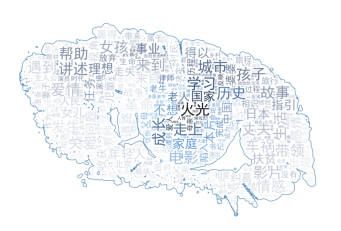

In [ ]:
import wordcloud
from PIL import Image
import matplotlib as mp
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

path_font = '/content/drive/MyDrive/Github/Content/tools/articles/fonts/simhei.ttf'
path_mask_image = "/content/drive/MyDrive/Github/Content/tools/articles/img/m2.png"
path_color_image = "/content/drive/MyDrive/Github/Content/tools/articles/img/machine-1776925.jpg"
path_img = '/content/drive/MyDrive/Github/Content/tools/articles/img'

# Extract Keywords from each summary
ls_kw = []
for s in df_view['梗概'].to_numpy():
  ls_kw.extend(textrank(s, topK=20))

# Append Title
ls_kw.extend(df_view['片名'].tolist())

# Append old title if diiferent from current title
ls_kw.extend([s for s in df_view['匹配片名'].tolist() if s!= ''])

#wordcloud.color_from_image(coloring)
mask = np.array(Image.open(path_mask_image)) # 定义词频背景

wc = wordcloud.WordCloud(
    font_path=path_font,
    width = 400,
    height = 100,
    scale = 1,
    mask=mask, # set back ground mask image
    max_words=444,
    max_font_size=88,
    #background_color="white", 
    background_color="rgba(255, 255, 255, 0)", 
    #mode="RGBA",
    mode="RGB",
    contour_width=3, 
    contour_color='steelblue',
    repeat=True,
    #color_func=image_colors,
)
wc.generate(','.join(ls_kw))

coloring = np.array(Image.open(path_color_image)) # Load Image for coloring
#image_colors = wordcloud.ImageColorGenerator(mask, default_color=(79, 46, 47))
image_colors = wordcloud.ImageColorGenerator(coloring)
wc.recolor(color_func=image_colors,  random_state=3)

plt.imshow(wc) # 显示词云
plt.axis('off') # 关闭坐标轴
plt.show()

wc.to_file(path_img + '/ChinaFilm_NewReleases_Overview_' + str_date_curr_release + '.png')


##[4.3] 怀胎最久的影片是《红船》,从

In [ ]:
P2 = '\t'
P2 += '怀胎最久的影片是《{}》,'.format(df_view.iloc[0]['片名'])
P2 += '从备案到获得公映证超过{}年，'.format(df_view.iloc[0]['备案至今'].lstrip('> ').rstrip(' 年'))
#P2 += '名字从《{}》进化成了《{}》，'.format(df_view.iloc[0]['匹配片名'], df_view.iloc[0]['片名'])
P2 += '第一出品方历经了{},最终由{}接棒。'.format(df_view.iloc[0]['原备案单位'], df_view.iloc[0]['第一出品单位'])
ls_choices = ['美好', '胜利', '牛逼']
#P2 += '坚持就是{}。'.format(ls_choices[random.randint(0,len(ls_choices)-1)])

print(P2)

	怀胎最久的影片是《红船》,从备案到获得公映证超过9.7年，第一出品方历经了八一电影制片厂,最终由浙江影视（集团）有限公司接棒。


In [ ]:
df_view.shape[0]

55

## [4.4] 同样坚守的还有...

In [ ]:
ls_name_3plus_year = df_view.loc[df_view['备案至今'].apply(lambda x: float(x.lstrip('> ').rstrip(' 年')))>3, '片名'].tolist()[1:]
ls_name_3plus_year = ['《'+ name + '》' for name in ls_name_3plus_year]
P3 = "\t"
P3 += '同样坚守了多年的影片还有{}等。'.format('、'.join(ls_name_3plus_year))
P3 += '本期有着大量的革命题材影片，由上市公司推动的就有腾讯的《1921》和光线的《革命者》。'
P3 += '青春片也不少，如《只是一次偶然的旅行》、《野马分鬃》、《五个扑水的少年》、《二哥来了怎么办》等。'
P3 += '宠物题材的影片由两部，《狗果定理》和《盗狗》，其中《狗果定理》经历了更换编剧与一次备案延期。'

print(P3)

	同样坚守了多年的影片还有《狗果定理》、《宋庆龄和福利院的孩子们》、《杜鹃改嫁（下）吕剧》、《功夫精灵》、《测谎人》、《你们不在的时光》、《永远的记忆之血战黎明前》、《天下第一镖2长风厉》、《天之书》、《山桃花》、《盗狗》、《米乐的完美夏天》等。本期有着大量的革命题材影片，由上市公司推动的就有腾讯的《1921》和光线的《革命者》。青春片也不少，如《只是一次偶然的旅行》、《野马分鬃》、《五个扑水的少年》、《二哥来了怎么办》等。宠物题材的影片由两部，《狗果定理》和《盗狗》，其中《狗果定理》经历了更换编剧与一次备案延期。


## [4.4a] 上市公司相关

In [ ]:
# 本批次中与上市影视公司关联的项目有
info_public_film_co = pd.read_csv('/content/drive/MyDrive/Github/Content/tools/articles/reference/info_public_film_co.csv', index_col=0, encoding='utf-8-sig')
ls = info_public_film_co['公司简称'].apply(eval).sum()
pat_public = '|'.join(ls)
pat_public += '|阿里|腾讯|爱奇艺|英皇|寰亚|银都|美亚|大盛|儒意|灿星|横店'
df_focus = df_view.loc[df_view['第一出品单位'].str.contains(pat_public, regex=True)]
df_focus = df_focus[df_focus['片名'] != '顺子加油']
df_focus

In [ ]:
P4 = '\t'
P4 += '本批次中，大数据分析识别出{}部上市影视公司关联项目，'.format(df_focus.shape[0])
P4 += '占比{}%。'.format(round( (df_focus.shape[0]/(df_view.shape[0]-1)*100), 2 ) )
P4 += '结合题材与出品方实力，慷田AI聚焦关注以下项目，题材类型包括了革命献礼和青春剧情。'
P4 += '一图理解本期题材关键词。\n'

## [4.5] 指向电影官网

In [ ]:
#####
E1 = '\n\n'
E1 += '\t'
E1 += '慷田AI结合自主调研及多方大数据比对，通过分析、建模，提炼关键信息。'
E1 += '公映许可证公示信息来自中国国家电影局 China Film Administration, 官方网址 '
E1 += ' http://www.chinafilm.gov.cn/chinafilm 。\n'
E1 += '\t本期慷田AI影片信息汇总：'

print(E1)



	慷田AI结合自主调研及多方大数据比对，通过分析、建模，提炼关键信息。公映许可证公示信息来自中国国家电影局 China Film Administration, 官方网址  http://www.chinafilm.gov.cn/chinafilm 。
	本期慷田AI影片信息汇总：


In [ ]:
 df_view['片名'].to_numpy()[0:5]

array(['守岛人', '阳光姐妹淘', '多乐路', '射雕英雄传之降龙十八掌', '丑角'], dtype=object)

## [4.6] 生成摘要

In [ ]:
S0 = '{}月新片{}部，'.format(dt_curr_release.month, df_curr_releases.shape[0])
S0 += '平均孕期超{}年，'.format(round(df_view['备案至今'].apply(lambda x: float(x.lstrip('> ').rstrip(' 年'))).mean(),1))
S0 += '改名的{}部，'.format(df.loc[df_view['匹配片名'] == '',:].shape[0])
S0 += '换主的{}部，'.format(df.loc[df_view['原备案单位'] == '',:].shape[0])
S0 += '慷田AI聚焦'
focus = ['《'+ name + '》' for name in df_focus['片名'].to_numpy()]
S0 += '{}'.format('、'.join(focus))
S0 += '…'

print(S0)

7月新片55部，平均孕期超2.4年，改名的33部，换主的41部，慷田AI聚焦《野马分鬃》、《只是一次偶然的旅行》、《五个扑水的少年》、《二哥来了怎么办》、《革命者》、《1921》…


# [5] Output Word Doc

## [5.1] Install Docx Lib

In [ ]:
!pip install python-docx
!pip install lxml
from docx import Document
from docx.shared import Inches
#from docx.text.parargaph import Paragraph

from docx.shared import Pt

     |████████████████████████████████| 5.6MB 4.3MB/s 
  Created wheel for python-docx: filename=python_docx-0.8.11-cp37-none-any.whl size=184508 sha256=4c3d676880912ea6c3da07bd80d2a78531637043fa590c612ed8a772b9e0a44b
  Stored in directory: /root/.cache/pip/wheels/a6/90/f1/a7cb70b38633ae04e7fb963b1c70f63fd6fc01c075b8230adc
Successfully built python-docx


In [ ]:
df_view

,片名,匹配片名,梗概,备案至今,是否修改,第一出品单位,原备案单位,编剧
32,红船,,今天的我们很难想象刀光剑影，血流成河的战场到底是什么样子。当我们学习到那些过往的岁月，才明白...,> 9.7 年,是,浙江影视（集团）有限公司,八一电影制片厂,祝新运
29,狗果定理,幸福像果汁一样,一只普通的年迈的狗果汁与主人走失的一个月，其间遇到形形色色的人，每个人都有自己的问题，但对待...,> 4.9 年,,北影视界国际文化传媒（北京）有限公司,,徐建辉
1,宋庆龄和福利院的孩子们,怒放,该片以一群孤儿的视角反应了宋庆龄关爱下一代的故事，讲述了建国初期，宋庆龄一心扑在祖国儿童福利...,> 4.9 年,,八一电影制片厂,,张元龙
39,杜鹃改嫁（下）吕剧,杜鹃改嫁,杜鹃改嫁，把丈夫车祸的赔偿款全部留给了婆婆。吴来贪图钱财，假意孝顺将婶母的钱骗到手后，百般虐...,> 4.6 年,,山东古楚兰风文化传媒有限公司,,楚瀚（范中华）
37,功夫精灵,,麻小凡是一个淘气、善良的孤儿，他有一项超能力，就是可以将上一次未做完的梦继续做下去，有一次他...,> 4.5 年,是,山东尹利堂影视传媒有限公司,中谊天润（北京）文化传媒有限公司、北京圆超杰影视文化传播有限公司,吴劲
53,测谎人,,一个能用耳朵分辨谎言且从不说谎的年轻人与一个落魄的经纪人开展了一项帮人测谎的业务。经过情感的...,> 4.4 年,,北京乐动花开影业有限公司,,沙海龙
41,你们不在的时光,老师妈妈,人民教师刘月娟，象妈妈一样不仅关心留守儿童的学习，更关心孩子们的成长，关心留守儿童的生活，用...,> 4.0 年,,驻马店市影视文化有限公司,,周明理
7,永远的记忆之血战黎明前,永远的记忆,北京举办“战争年代的记忆”图片展，泛黄的老照片唤醒了俄罗斯老人苏拉的记忆。1945年战火还未...,> 3.6 年,,西安沣镐嘉艺影视文化传播有限公司,,乙福海
8,天下第一镖2长风厉,天下第一镖局2,\t景亮听闻清平镖局杨六安信守承诺，逐以杨六安为榜样，建立新的清平镖局，机缘巧合之下与杨六安...,> 3.6 年,是,北京盛世华映影视文化传播有限公司,,刘崇崇、陶江华
44,天之书,,“書中自有黄金屋，书中自颜如玉”书中蕴藏着多少奥秘？黄金屋和颜如玉又是否真的存在？也许在一个...,> 3.6 年,,浙江艺霏文化传媒有限公司,,王刚


## Write to docx

In [ ]:
path_doc = '/content/drive/MyDrive/Github/Content/tools/articles/docx'
path_img = '/content/drive/MyDrive/Github/Content/tools/articles/img'

doc = Document()
doc.core_properties.title = 'ChinaFilm_NewReleases_Overview_' + str_date_curr_release
style = doc.styles['Normal']
font = style.font
font.name = 'simhei'
font.size = Pt(12)

doc.add_heading(T1, 0)

p = doc.add_paragraph(S0, style='Intense Quote')

doc.add_paragraph(P1)

doc.add_picture(path_img + '/posters/' + '1921_h_2021.jpg', width =Inches(6))

doc.add_paragraph(P2)

doc.add_paragraph(P3)

doc.add_paragraph(P4)
doc.add_picture(path_img + '/ChinaFilm_NewReleases_Overview_'
                  + str_date_curr_release + '.png', width =Inches(6)
               )

table = doc.add_table(rows=1, cols=1, style='Light List Accent 4')
i = 1
for _, row in df_focus.iterrows():
  row_cells = table.add_row().cells
  row_cells[0].text = '[' + str(i) + ']' + '《'.format(i) + row['片名'] + '》'
  i += 1


doc.add_paragraph(E1)

table = doc.add_table(rows=1, cols=1, style='Light List Accent 4')
i = 1
for _, row in df_view.iterrows():
  row_cells = table.add_row().cells
  row_cells[0].text = '[' + str(i) + ']' + '《'.format(i) + row['片名'] + '》'
  if row['匹配片名'] != '':
    row_cells[0].text += ' (原备案名《{}》)'.format(row['匹配片名'])

  row_cells = table.add_row().cells
  row_cells[0].text = '编剧: ' + row['编剧'] 
  
  row_cells = table.add_row().cells
  row_cells[0].text = '距离备案 ' + row['备案至今']
  if row['是否修改'] == '是':
    row_cells[0].text += ', 修改后通过备案'

  row_cells = table.add_row().cells
  row_cells[0].text = '第一出品单位: ' + row['第一出品单位']
  if row['原备案单位'] != '': 
    row_cells = table.add_row().cells
    row_cells[0].text = '原备案单位：{}）'.format(row['原备案单位'])

  row_cells = table.add_row().cells
  row_cells[0].text = row['梗概'].lstrip('\w+')

  row_cells = table.add_row().cells
  row_cells[0].text = ''
  i+=1


doc.save(path_doc + '/ChinaFilm_NewReleases_Overview_' + str_date_curr_release +'.docx' )